In [51]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os, glob, parse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

ligan_dir = '/home/mtr22/bridges/pylon5/mc5phpp/mtragoza/liGAN'
sys.path.append(ligan_dir)

from results import aggregate_data, add_group_column, plot_strips, plot_dist, plot_corr

work_dir = os.path.join(ligan_dir, 'test_atom_fitting')
os.chdir(work_dir)
os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/home/mtr22/bridges/pylon5/mc5phpp/mtragoza/liGAN/test_atom_fitting'

In [2]:
metric_files = []
with open('metrics_ae_lowrmsdtest0') as f:
    for line in f:
        metric_file = line.rstrip()
        if metric_file:
            metric_files.append(metric_file)

metric_files = sorted(set(metric_files))
len(metric_files)

54

In [69]:
def ob_mol_to_rd_mol(ob_mol):

    n_atoms = ob_mol.NumAtoms()
    rd_mol = Chem.RWMol()
    rd_conf = Chem.Conformer(n_atoms)

    for ob_atom in ob.OBMolAtomIter(ob_mol):
        rd_atom = Chem.Atom(ob_atom.GetAtomicNum())
        i = rd_mol.AddAtom(rd_atom)
        ob_coords = ob_atom.GetVector()
        x = ob_coords.GetX()
        y = ob_coords.GetY()
        z = ob_coords.GetZ()
        rd_coords = Geometry.Point3D(x, y, z)
        rd_conf.SetAtomPosition(i, rd_coords)

    rd_mol.AddConformer(rd_conf)

    for ob_bond in ob.OBMolBondIter(ob_mol):
        i = ob_bond.GetBeginAtomIdx()-1
        j = ob_bond.GetEndAtomIdx()-1
        bond_order = ob_bond.GetBondOrder()
        if bond_order == 1:
            rd_mol.AddBond(i, j, Chem.BondType.SINGLE)
        elif bond_order == 2:
            rd_mol.AddBond(i, j, Chem.BondType.DOUBLE)
        elif bond_order == 3:
            rd_mol.AddBond(i, j, Chem.BondType.TRIPLE)
        else:
            raise Exception('unknown bond order {}'.format(bond_order))

    return rd_mol

def compute_validity(fit_df):
    
    grid_names = ['lig_fit', 'lig_gen_fit']
    n_total = len(fit_df) * len(grid_names)
    
    from openbabel import openbabel as ob
    from rdkit import Chem, Geometry
    conv = ob.OBConversion()
    conv.SetInFormat('sdf')
    
    for i, row in fit_df.iterrows():
        fit_name = row['fit_name']
        lig_name = row['lig_name']
        sample_idx = row['sample_idx']
        for grid_name in grid_names:
            sdf_base = '{}_{}_{}_{}.sdf'.format(fit_name, lig_name, grid_name, sample_idx)
            sdf_file = os.path.join('ae_lowrmsdtest0', fit_name, '7637380', sdf_base)
            try:
                mol = ob.OBMol()
                conv.ReadFile(mol, sdf_file)
                mol.ConnectTheDots()
                mol.PerceiveBondOrders()
                mol = ob_mol_to_rd_mol(mol)
                try:
                    Chem.SanitizeMol(mol)
                except Chem.MolSanitizeException as e:
                    error = e
                else:
                    error = None

                n_frags = len(Chem.GetMolFrags(mol))
                fit_df.loc[i, grid_name+'_error'] = error
                fit_df.loc[i, grid_name+'_n_frags'] = n_frags

            except Exception as e:
                print(sdf_file, file=sys.stderr)
                raise e
        if (i+1)%100 == 0:
            print(i+1, '/', n_total)

In [70]:
name_format = '{gen_options}_{r_factor:.2f}_{interm_iters:d}_{final_iters:d}'

remove_cols = ['lig_norm', 'lig_gen_norm', 'lig_gen_loss',
               'lig_var', 'lig_gen_var',
               'lig_fit_n_atoms', 'lig_gen_fit_n_atoms',
               'lig_fit_radius', 'lig_gen_fit_radius']

fit_dfs = []
for metric_file in metric_files:
    try:
        fit_df = pd.read_csv(metric_file, sep=' ')
    except Exception as e:
        print(metric_file, e, file=sys.stderr)
        continue
    
    for c in remove_cols:
        del fit_df[c]
    
    fit_name = os.path.splitext(os.path.basename(metric_file))[0]
    fit_params = parse.parse(name_format, fit_name).named
    
    fit_df['fit_name'] = fit_name
    for param, value in fit_params.items():
        fit_df[param] = value
        
    fit_df['sample_idx'] = fit_df['sample_idx'].apply(str)
    fit_df['r_factor'] = fit_df['r_factor'].apply(lambda x: int(100*x))
    fit_df['random_rotation'] = fit_df['gen_options'].apply(lambda x: 'r' in x)
    fit_df['constrain_types'] = fit_df['gen_options'].apply(lambda x: 'c' in x)
    fit_df['lig_fit_correct_types'] = (fit_df['lig_fit_type_diff'] == 0)
    fit_df['lig_gen_fit_correct_types'] = (fit_df['lig_gen_fit_type_diff'] == 0)
    
    if fit_name == 'r_1.0_10_100' and True:
        compute_validity(fit_df)
    
    fit_dfs.append(fit_df)

df = pd.concat(fit_dfs)
df.head()

ae_lowrmsdtest0/r_0.9_10_25/7637360/r_0.9_10_25.gen_metrics No columns to parse from file
RDKit ERROR: [16:45:03] Explicit valence for atom # 28 N, 4, is greater than permitted
RDKit ERROR: [16:45:03] Explicit valence for atom # 27 N, 4, is greater than permitted
RDKit ERROR: [16:45:05] Explicit valence for atom # 28 N, 4, is greater than permitted
RDKit ERROR: [16:45:06] Explicit valence for atom # 38 N, 4, is greater than permitted
RDKit ERROR: [16:45:07] Explicit valence for atom # 33 N, 4, is greater than permitted
RDKit ERROR: [16:45:07] Explicit valence for atom # 36 N, 4, is greater than permitted
RDKit ERROR: [16:45:07] Explicit valence for atom # 20 N, 4, is greater than permitted
RDKit ERROR: [16:45:08] Explicit valence for atom # 32 N, 4, is greater than permitted
RDKit ERROR: [16:45:08] Explicit valence for atom # 34 N, 4, is greater than permitted
RDKit ERROR: [16:45:08] Explicit valence for atom # 30 N, 4, is greater than permitted
RDKit ERROR: [16:45:09] Explicit valence

100 / 16300
200 / 16300


RDKit ERROR: [16:45:22] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [16:45:23] Explicit valence for atom # 20 N, 4, is greater than permitted


300 / 16300


RDKit ERROR: [16:45:27] Explicit valence for atom # 23 C, 5, is greater than permitted
RDKit ERROR: [16:45:28] Explicit valence for atom # 33 C, 5, is greater than permitted
RDKit ERROR: [16:45:29] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [16:45:31] Explicit valence for atom # 14 C, 5, is greater than permitted
RDKit ERROR: [16:45:31] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [16:45:31] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:45:32] Explicit valence for atom # 13 C, 5, is greater than permitted
RDKit ERROR: [16:45:32] Explicit valence for atom # 10 C, 5, is greater than permitted


400 / 16300


RDKit ERROR: [16:45:39] Explicit valence for atom # 16 C, 5, is greater than permitted


500 / 16300
600 / 16300
700 / 16300
800 / 16300
900 / 16300


RDKit ERROR: [16:46:19] Explicit valence for atom # 13 N, 4, is greater than permitted


1000 / 16300


RDKit ERROR: [16:46:28] Explicit valence for atom # 13 N, 5, is greater than permitted


1100 / 16300
1200 / 16300
1300 / 16300
1400 / 16300


RDKit ERROR: [16:46:48] Explicit valence for atom # 27 C, 5, is greater than permitted


1500 / 16300
1600 / 16300
1700 / 16300


RDKit ERROR: [16:47:07] Explicit valence for atom # 28 N, 4, is greater than permitted
RDKit ERROR: [16:47:08] Explicit valence for atom # 35 N, 4, is greater than permitted
RDKit ERROR: [16:47:08] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [16:47:08] Explicit valence for atom # 23 N, 4, is greater than permitted
RDKit ERROR: [16:47:08] Explicit valence for atom # 24 N, 4, is greater than permitted


1800 / 16300
1900 / 16300


RDKit ERROR: [16:47:22] Explicit valence for atom # 29 N, 4, is greater than permitted


2000 / 16300
2100 / 16300
2200 / 16300
2300 / 16300


RDKit ERROR: [16:47:40] Explicit valence for atom # 12 C, 5, is greater than permitted


2400 / 16300


RDKit ERROR: [16:47:47] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [16:47:48] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [16:47:48] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [16:47:48] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [16:47:48] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [16:47:48] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [16:47:48] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [16:47:48] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [16:47:48] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [16:47:48] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [16:47:48] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [16:47:48] Explicit valence for atom # 6 

2500 / 16300


RDKit ERROR: [16:47:51] Explicit valence for atom # 21 N, 4, is greater than permitted
RDKit ERROR: [16:47:54] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [16:47:54] Explicit valence for atom # 30 C, 5, is greater than permitted
RDKit ERROR: [16:47:54] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [16:47:54] Explicit valence for atom # 13 C, 5, is greater than permitted
RDKit ERROR: [16:47:54] Explicit valence for atom # 13 C, 5, is greater than permitted
RDKit ERROR: [16:47:54] Explicit valence for atom # 14 C, 5, is greater than permitted


2600 / 16300


RDKit ERROR: [16:47:55] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [16:47:56] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [16:47:56] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [16:47:56] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [16:47:56] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [16:47:56] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [16:47:56] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [16:47:56] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [16:47:56] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [16:47:56] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [16:47:56] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [16:47:56] Explicit valence for atom # 4 

2700 / 16300
2800 / 16300
2900 / 16300


RDKit ERROR: [16:48:12] Explicit valence for atom # 13 C, 5, is greater than permitted
RDKit ERROR: [16:48:12] Explicit valence for atom # 43 N, 4, is greater than permitted
RDKit ERROR: [16:48:12] Explicit valence for atom # 28 N, 4, is greater than permitted
RDKit ERROR: [16:48:13] Explicit valence for atom # 38 N, 4, is greater than permitted
RDKit ERROR: [16:48:13] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:48:13] Explicit valence for atom # 27 C, 5, is greater than permitted
RDKit ERROR: [16:48:13] Explicit valence for atom # 21 N, 4, is greater than permitted
RDKit ERROR: [16:48:13] Explicit valence for atom # 32 N, 4, is greater than permitted
RDKit ERROR: [16:48:13] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [16:48:13] Explicit valence for atom # 40 N, 4, is greater than permitted
RDKit ERROR: [16:48:14] Explicit valence for atom # 45 C, 5, is greater than permitted
RDKit ERROR: [16:48:14] Explicit valence for

3000 / 16300
3100 / 16300


RDKit ERROR: [16:48:23] Explicit valence for atom # 25 C, 5, is greater than permitted
RDKit ERROR: [16:48:23] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:48:25] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [16:48:25] Explicit valence for atom # 28 C, 5, is greater than permitted


3200 / 16300


RDKit ERROR: [16:48:28] Explicit valence for atom # 22 N, 4, is greater than permitted
RDKit ERROR: [16:48:29] Explicit valence for atom # 34 C, 5, is greater than permitted
RDKit ERROR: [16:48:30] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [16:48:31] Explicit valence for atom # 15 C, 5, is greater than permitted


3300 / 16300
3400 / 16300


RDKit ERROR: [16:48:39] Explicit valence for atom # 31 C, 5, is greater than permitted
RDKit ERROR: [16:48:39] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:48:40] Explicit valence for atom # 29 C, 5, is greater than permitted
RDKit ERROR: [16:48:40] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:48:41] Explicit valence for atom # 28 N, 4, is greater than permitted
RDKit ERROR: [16:48:41] Explicit valence for atom # 15 C, 5, is greater than permitted
RDKit ERROR: [16:48:41] Explicit valence for atom # 25 N, 4, is greater than permitted
RDKit ERROR: [16:48:42] Explicit valence for atom # 25 C, 5, is greater than permitted
RDKit ERROR: [16:48:43] Explicit valence for atom # 31 C, 5, is greater than permitted


3500 / 16300


RDKit ERROR: [16:48:43] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [16:48:44] Explicit valence for atom # 17 C, 5, is greater than permitted
RDKit ERROR: [16:48:44] Explicit valence for atom # 16 C, 5, is greater than permitted
RDKit ERROR: [16:48:44] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [16:48:44] Explicit valence for atom # 14 C, 5, is greater than permitted
RDKit ERROR: [16:48:45] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [16:48:45] Explicit valence for atom # 13 C, 5, is greater than permitted
RDKit ERROR: [16:48:46] Explicit valence for atom # 27 N, 4, is greater than permitted


3600 / 16300


RDKit ERROR: [16:48:49] Explicit valence for atom # 44 C, 5, is greater than permitted
RDKit ERROR: [16:48:51] Explicit valence for atom # 22 C, 5, is greater than permitted
RDKit ERROR: [16:48:51] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:48:52] Explicit valence for atom # 25 N, 4, is greater than permitted
RDKit ERROR: [16:48:52] Explicit valence for atom # 14 C, 5, is greater than permitted
RDKit ERROR: [16:48:55] Explicit valence for atom # 7 N, 4, is greater than permitted


3700 / 16300


RDKit ERROR: [16:48:55] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [16:48:55] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [16:48:56] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [16:48:56] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [16:48:56] Explicit valence for atom # 32 N, 4, is greater than permitted
RDKit ERROR: [16:48:57] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [16:48:57] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [16:48:58] Explicit valence for atom # 47 N, 4, is greater than permitted
RDKit ERROR: [16:49:00] Explicit valence for atom # 52 N, 4, is greater than permitted
RDKit ERROR: [16:49:00] Explicit valence for atom # 44 N, 4, is greater than permitted
RDKit ERROR: [16:49:01] Explicit valence for atom # 44 N, 4, is greater than permitted
RDKit ERROR: [16:49:01] Explicit valence for 

3800 / 16300


RDKit ERROR: [16:49:02] Explicit valence for atom # 34 N, 4, is greater than permitted
RDKit ERROR: [16:49:02] Explicit valence for atom # 44 N, 4, is greater than permitted
RDKit ERROR: [16:49:03] Explicit valence for atom # 41 N, 4, is greater than permitted
RDKit ERROR: [16:49:03] Explicit valence for atom # 28 N, 4, is greater than permitted


3900 / 16300


RDKit ERROR: [16:49:10] Explicit valence for atom # 13 C, 5, is greater than permitted
RDKit ERROR: [16:49:10] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [16:49:10] Explicit valence for atom # 18 C, 5, is greater than permitted
RDKit ERROR: [16:49:10] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [16:49:10] Explicit valence for atom # 18 C, 5, is greater than permitted


4000 / 16300


RDKit ERROR: [16:49:12] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:49:12] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [16:49:12] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:49:12] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [16:49:12] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:49:12] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [16:49:12] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [16:49:12] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [16:49:12] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [16:49:12] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [16:49:12] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [16:49:12] Explicit valence for atom # 7

RDKit ERROR: [16:49:16] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [16:49:16] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [16:49:16] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [16:49:16] Explicit valence for atom # 5 N, 4, is greater than permitted


4100 / 16300


RDKit ERROR: [16:49:16] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [16:49:16] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [16:49:16] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [16:49:16] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [16:49:16] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [16:49:16] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [16:49:16] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [16:49:16] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [16:49:16] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [16:49:17] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [16:49:17] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [16:49:17] Explicit valence for atom # 6 

4200 / 16300


RDKit ERROR: [16:49:22] Explicit valence for atom # 1 C, 5, is greater than permitted


4300 / 16300


RDKit ERROR: [16:49:27] Explicit valence for atom # 23 N, 4, is greater than permitted
RDKit ERROR: [16:49:28] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [16:49:28] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [16:49:29] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [16:49:30] Explicit valence for atom # 32 C, 5, is greater than permitted
RDKit ERROR: [16:49:31] Explicit valence for atom # 43 C, 5, is greater than permitted


4400 / 16300


RDKit ERROR: [16:49:32] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [16:49:32] Explicit valence for atom # 35 C, 5, is greater than permitted
RDKit ERROR: [16:49:32] Explicit valence for atom # 13 C, 5, is greater than permitted
RDKit ERROR: [16:49:33] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:49:33] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [16:49:33] Explicit valence for atom # 13 C, 5, is greater than permitted
RDKit ERROR: [16:49:33] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:49:33] Explicit valence for atom # 13 C, 5, is greater than permitted
RDKit ERROR: [16:49:34] Explicit valence for atom # 25 N, 4, is greater than permitted
RDKit ERROR: [16:49:34] Explicit valence for atom # 30 N, 4, is greater than permitted
RDKit ERROR: [16:49:34] Explicit valence for atom # 23 N, 4, is greater than permitted
RDKit ERROR: [16:49:34] Explicit valence for at

4500 / 16300


RDKit ERROR: [16:49:36] Explicit valence for atom # 34 N, 4, is greater than permitted
RDKit ERROR: [16:49:36] Explicit valence for atom # 25 N, 4, is greater than permitted
RDKit ERROR: [16:49:36] Explicit valence for atom # 24 N, 4, is greater than permitted
RDKit ERROR: [16:49:36] Explicit valence for atom # 31 N, 4, is greater than permitted
RDKit ERROR: [16:49:37] Explicit valence for atom # 33 N, 4, is greater than permitted
RDKit ERROR: [16:49:37] Explicit valence for atom # 39 N, 4, is greater than permitted
RDKit ERROR: [16:49:38] Explicit valence for atom # 25 N, 4, is greater than permitted
RDKit ERROR: [16:49:38] Explicit valence for atom # 41 N, 4, is greater than permitted
RDKit ERROR: [16:49:38] Explicit valence for atom # 44 N, 4, is greater than permitted
RDKit ERROR: [16:49:39] Explicit valence for atom # 23 C, 5, is greater than permitted
RDKit ERROR: [16:49:39] Explicit valence for atom # 25 N, 4, is greater than permitted
RDKit ERROR: [16:49:40] Explicit valence fo

4600 / 16300


RDKit ERROR: [16:49:40] Explicit valence for atom # 42 N, 4, is greater than permitted
RDKit ERROR: [16:49:41] Explicit valence for atom # 24 C, 5, is greater than permitted
RDKit ERROR: [16:49:41] Explicit valence for atom # 25 N, 4, is greater than permitted
RDKit ERROR: [16:49:42] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [16:49:42] Explicit valence for atom # 25 N, 4, is greater than permitted


4700 / 16300
4800 / 16300


RDKit ERROR: [16:49:48] Explicit valence for atom # 12 C, 5, is greater than permitted


4900 / 16300


RDKit ERROR: [16:49:50] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [16:49:51] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [16:49:51] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [16:49:51] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [16:49:51] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [16:49:51] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [16:49:51] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [16:49:51] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [16:49:51] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [16:49:51] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [16:49:52] Explicit valence for atom # 10 C, 5, is greater than permitted


5000 / 16300


RDKit ERROR: [16:49:54] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [16:49:55] Explicit valence for atom # 7 C, 5, is greater than permitted


5100 / 16300
5200 / 16300
5300 / 16300
5400 / 16300
5500 / 16300


RDKit ERROR: [16:50:13] Explicit valence for atom # 16 C, 5, is greater than permitted
RDKit ERROR: [16:50:13] Explicit valence for atom # 16 C, 5, is greater than permitted
RDKit ERROR: [16:50:13] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [16:50:13] Explicit valence for atom # 36 N, 4, is greater than permitted
RDKit ERROR: [16:50:14] Explicit valence for atom # 17 C, 5, is greater than permitted
RDKit ERROR: [16:50:14] Explicit valence for atom # 45 N, 4, is greater than permitted
RDKit ERROR: [16:50:14] Explicit valence for atom # 25 N, 4, is greater than permitted
RDKit ERROR: [16:50:14] Explicit valence for atom # 23 C, 5, is greater than permitted
RDKit ERROR: [16:50:15] Explicit valence for atom # 23 C, 5, is greater than permitted
RDKit ERROR: [16:50:15] Explicit valence for atom # 20 C, 5, is greater than permitted
RDKit ERROR: [16:50:15] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [16:50:15] Explicit valence for 

5600 / 16300


RDKit ERROR: [16:50:16] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [16:50:16] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [16:50:17] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [16:50:17] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [16:50:17] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [16:50:17] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [16:50:18] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:50:18] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [16:50:18] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [16:50:19] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [16:50:19] Explicit valence for atom # 10 C, 5, is greater than permitted


5700 / 16300


RDKit ERROR: [16:50:19] Explicit valence for atom # 33 N, 4, is greater than permitted
RDKit ERROR: [16:50:19] Explicit valence for atom # 27 N, 4, is greater than permitted
RDKit ERROR: [16:50:20] Explicit valence for atom # 31 N, 4, is greater than permitted
RDKit ERROR: [16:50:20] Explicit valence for atom # 28 N, 4, is greater than permitted
RDKit ERROR: [16:50:20] Explicit valence for atom # 35 N, 4, is greater than permitted
RDKit ERROR: [16:50:20] Explicit valence for atom # 38 N, 4, is greater than permitted
RDKit ERROR: [16:50:20] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [16:50:20] Explicit valence for atom # 36 N, 4, is greater than permitted
RDKit ERROR: [16:50:21] Explicit valence for atom # 42 N, 4, is greater than permitted
RDKit ERROR: [16:50:21] Explicit valence for atom # 41 C, 5, is greater than permitted
RDKit ERROR: [16:50:21] Explicit valence for atom # 41 N, 4, is greater than permitted
RDKit ERROR: [16:50:21] Explicit valence for

5800 / 16300
5900 / 16300


RDKit ERROR: [16:50:25] Explicit valence for atom # 29 N, 4, is greater than permitted
RDKit ERROR: [16:50:25] Explicit valence for atom # 29 N, 4, is greater than permitted
RDKit ERROR: [16:50:25] Explicit valence for atom # 33 N, 4, is greater than permitted


6000 / 16300


RDKit ERROR: [16:50:28] Explicit valence for atom # 30 N, 4, is greater than permitted
RDKit ERROR: [16:50:29] Explicit valence for atom # 21 N, 4, is greater than permitted
RDKit ERROR: [16:50:29] Explicit valence for atom # 20 N, 4, is greater than permitted


6100 / 16300
6200 / 16300
6300 / 16300
6400 / 16300


RDKit ERROR: [16:50:38] Explicit valence for atom # 1 C, 5, is greater than permitted


6500 / 16300
6600 / 16300


RDKit ERROR: [16:50:42] Explicit valence for atom # 3 C, 5, is greater than permitted


6700 / 16300
6800 / 16300


RDKit ERROR: [16:50:44] Explicit valence for atom # 31 C, 5, is greater than permitted
RDKit ERROR: [16:50:44] Explicit valence for atom # 15 C, 5, is greater than permitted


6900 / 16300


RDKit ERROR: [16:50:46] Explicit valence for atom # 15 N, 4, is greater than permitted
RDKit ERROR: [16:50:47] Explicit valence for atom # 15 N, 4, is greater than permitted
RDKit ERROR: [16:50:47] Explicit valence for atom # 20 N, 4, is greater than permitted
RDKit ERROR: [16:50:47] Explicit valence for atom # 29 N, 4, is greater than permitted
RDKit ERROR: [16:50:47] Explicit valence for atom # 27 N, 4, is greater than permitted
RDKit ERROR: [16:50:47] Explicit valence for atom # 18 C, 5, is greater than permitted
RDKit ERROR: [16:50:47] Explicit valence for atom # 26 C, 5, is greater than permitted


7000 / 16300
7100 / 16300
7200 / 16300
7300 / 16300


RDKit ERROR: [16:50:52] Explicit valence for atom # 11 C, 5, is greater than permitted


7400 / 16300


RDKit ERROR: [16:50:55] Explicit valence for atom # 23 N, 4, is greater than permitted


7500 / 16300
7600 / 16300


RDKit ERROR: [16:50:57] Explicit valence for atom # 37 N, 4, is greater than permitted


7700 / 16300


RDKit ERROR: [16:50:59] Explicit valence for atom # 27 N, 4, is greater than permitted


7800 / 16300


RDKit ERROR: [16:51:00] Explicit valence for atom # 27 N, 4, is greater than permitted
RDKit ERROR: [16:51:00] Explicit valence for atom # 21 N, 4, is greater than permitted
RDKit ERROR: [16:51:00] Explicit valence for atom # 26 C, 5, is greater than permitted
RDKit ERROR: [16:51:00] Explicit valence for atom # 21 N, 4, is greater than permitted
RDKit ERROR: [16:51:00] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [16:51:00] Explicit valence for atom # 37 N, 4, is greater than permitted
RDKit ERROR: [16:51:00] Explicit valence for atom # 34 N, 4, is greater than permitted
RDKit ERROR: [16:51:00] Explicit valence for atom # 20 N, 4, is greater than permitted
RDKit ERROR: [16:51:00] Explicit valence for atom # 37 N, 4, is greater than permitted
RDKit ERROR: [16:51:00] Explicit valence for atom # 17 N, 4, is greater than permitted


7900 / 16300


RDKit ERROR: [16:51:02] Explicit valence for atom # 28 N, 4, is greater than permitted
RDKit ERROR: [16:51:02] Explicit valence for atom # 34 N, 4, is greater than permitted
RDKit ERROR: [16:51:02] Explicit valence for atom # 34 N, 4, is greater than permitted
RDKit ERROR: [16:51:02] Explicit valence for atom # 28 N, 4, is greater than permitted
RDKit ERROR: [16:51:02] Explicit valence for atom # 35 N, 4, is greater than permitted
RDKit ERROR: [16:51:03] Explicit valence for atom # 25 N, 4, is greater than permitted
RDKit ERROR: [16:51:03] Explicit valence for atom # 48 N, 4, is greater than permitted
RDKit ERROR: [16:51:03] Explicit valence for atom # 28 N, 4, is greater than permitted


8000 / 16300


RDKit ERROR: [16:51:04] Explicit valence for atom # 43 N, 4, is greater than permitted
RDKit ERROR: [16:51:04] Explicit valence for atom # 45 N, 4, is greater than permitted
RDKit ERROR: [16:51:04] Explicit valence for atom # 33 N, 4, is greater than permitted
RDKit ERROR: [16:51:04] Explicit valence for atom # 32 N, 4, is greater than permitted
RDKit ERROR: [16:51:04] Explicit valence for atom # 45 N, 4, is greater than permitted
RDKit ERROR: [16:51:04] Explicit valence for atom # 25 N, 4, is greater than permitted
RDKit ERROR: [16:51:05] Explicit valence for atom # 40 N, 4, is greater than permitted
RDKit ERROR: [16:51:05] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [16:51:05] Explicit valence for atom # 46 N, 4, is greater than permitted
RDKit ERROR: [16:51:05] Explicit valence for atom # 43 N, 4, is greater than permitted
RDKit ERROR: [16:51:05] Explicit valence for atom # 25 N, 4, is greater than permitted
RDKit ERROR: [16:51:05] Explicit valence fo

8100 / 16300


RDKit ERROR: [16:51:05] Explicit valence for atom # 33 N, 4, is greater than permitted
RDKit ERROR: [16:51:06] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [16:51:06] Explicit valence for atom # 25 N, 4, is greater than permitted


,lig_name,sample_idx,lig_fit_loss,lig_gen_fit_loss,lig_fit_type_diff,lig_gen_fit_type_diff,lig_fit_time,lig_gen_fit_time,lig_fit_lig_gen_fit_type_diff,lig_gen_fit_RMSD,...,interm_iters,final_iters,random_rotation,constrain_types,lig_fit_correct_types,lig_gen_fit_correct_types,lig_fit_error,lig_fit_n_frags,lig_gen_fit_error,lig_gen_fit_n_frags
0,1ajv_ligand_0,0,0.002762,34.578167,0.0,5.0,8.338402,3.954750,5.0,NaN,...,10,100,True,False,True,False,NaN,NaN,NaN,NaN
1,1ajv_ligand_0,1,0.000487,34.911293,0.0,4.0,3.989206,3.880471,4.0,NaN,...,10,100,True,False,True,False,NaN,NaN,NaN,NaN
2,1ajv_ligand_0,2,0.000196,33.513668,0.0,4.0,3.990307,3.889691,4.0,NaN,...,10,100,True,False,True,False,NaN,NaN,NaN,NaN
3,1ajv_ligand_0,3,0.114922,34.608593,0.0,5.0,3.977180,4.124665,5.0,NaN,...,10,100,True,False,True,False,NaN,NaN,NaN,NaN
4,1ajv_ligand_0,4,0.019176,46.647320,0.0,4.0,3.980007,3.706057,4.0,NaN,...,10,100,True,False,True,False,NaN,NaN,NaN,NaN


In [4]:
agg_df = aggregate_data(df, ['fit_name'])
agg_df.head()

,lig_name,sample_idx,lig_fit_loss,lig_gen_fit_loss,lig_fit_type_diff,lig_gen_fit_type_diff,lig_fit_time,lig_gen_fit_time,lig_fit_lig_gen_fit_type_diff,lig_gen_fit_RMSD,gen_options,r_factor,interm_iters,final_iters,random_rotation,constrain_types,lig_fit_correct_types,lig_gen_fit_correct_types
fit_name,,,,,,,,,,,,,,,,,,
r_0.95_10_100,322,25,0.053476,20.295962,0.006708,1.916273,2.654308,2.638976,1.916522,0.261767,1,95,10,100,True,False,0.993913,0.209565
r_0.95_10_25,344,25,0.312032,20.730119,0.006512,1.952093,2.474539,2.476939,1.952326,0.273721,1,95,10,25,True,False,0.994070,0.202093
r_0.95_10_50,334,25,0.101137,20.641604,0.006707,1.946467,2.552746,2.549484,1.946946,0.265274,1,95,10,50,True,False,0.993892,0.204072
r_0.95_1_100,416,25,2.197462,20.346908,0.350000,1.864808,2.028140,2.029428,2.022692,0.299431,1,95,1,100,True,False,0.692596,0.228269
r_0.95_1_25,453,25,2.868820,21.127903,0.352759,1.880265,1.856533,1.874983,2.040000,0.322125,1,95,1,25,True,False,0.691126,0.227285


In [71]:
%matplotlib inline
sns.set_context('notebook')
sns.set_style('white')
    
params = ['constrain_types', 'r_factor', 'interm_iters', 'final_iters']
metrics = [
    'lig_fit_time',          'lig_gen_fit_time',
    'lig_fit_loss',          'lig_gen_fit_loss',
    'lig_fit_correct_types', 'lig_gen_fit_correct_types',
    'lig_gen_fit_type_diff', 'lig_gen_fit_RMSD'
]

plot_df = aggregate_data(df, ['fit_name', 'lig_name'])

for p in params:
    add_group_column(plot_df, [p2 for p2 in params if p2 != p])

plot_df.head()

sample_idx  lig_fit_loss  lig_gen_fit_loss  \
fit_name      lig_name                                                     
r_0.95_10_100 1ajv_ligand_0           25      0.098085         37.813254   
              1ajv_min                25      0.064851         31.501860   
              1ajx_ligand_2           25      0.444321         27.332015   
              1ajx_ligand_5           25      0.168783         26.500940   
              1alw_ligand_10          25      0.044803          4.198219   

                              lig_fit_type_diff  lig_gen_fit_type_diff  \
fit_name      lig_name                                                   
r_0.95_10_100 1ajv_ligand_0                0.00                   4.00   
              1ajv_min                     0.00                   3.48   
              1ajx_ligand_2                0.08                   3.44   
              1ajx_ligand_5                0.00                   3.92   
              1alw_ligand_10               0.00                   1.00   

                              lig_fit_time  lig_gen_fit_time  \
fit_name      lig_name                                         
r_0.95_10_100 1ajv_ligand_0       4.152830          3.861843   
              1ajv_min            3.984740          3.961787   
              1ajx_ligand_2       3.880508          3.884873   
              1ajx_ligand_5       3.889541          3.937986   
              1alw_ligand_10      1.383999          1.425353   

                              lig_fit_lig_gen_fit_type_diff  lig_gen_fit_RMSD  \
fit_name      lig_name                                                          
r_0.95_10_100 1ajv_ligand_0                            4.00               NaN   
              1ajv_min                                 3.48               NaN   
              1ajx_ligand_2                            3.52               NaN   
              1ajx_ligand_5                            3.92               NaN   
              1alw_ligand_10                           1.00               NaN   

                              gen_options  ...  lig_fit_correct_types  \
fit_name      lig_name                     ...                          
r_0.95_10_100 1ajv_ligand_0             1  ...                   1.00   
              1ajv_min                  1  ...                   1.00   
              1ajx_ligand_2             1  ...                   0.92   
              1ajx_ligand_5             1  ...                   1.00   
              1alw_ligand_10            1  ...                   1.00   

                              lig_gen_fit_correct_types  lig_fit_error  \
fit_name      lig_name                                                   
r_0.95_10_100 1ajv_ligand_0                         0.0              0   
              1ajv_min                              0.0              0   
              1ajx_ligand_2                         0.0              0   
              1ajx_ligand_5                         0.0              0   
              1alw_ligand_10                        0.0              0   

                              lig_fit_n_frags  lig_gen_fit_error  \
fit_name      lig_name                                             
r_0.95_10_100 1ajv_ligand_0               NaN                  0   
              1ajv_min                    NaN                  0   
              1ajx_ligand_2               NaN                  0   
              1ajx_ligand_5               NaN                  0   
              1alw_ligand_10              NaN                  0   

                              lig_gen_fit_n_frags  \
fit_name      lig_name                              
r_0.95_10_100 1ajv_ligand_0                   NaN   
              1ajv_min                        NaN   
              1ajx_ligand_2                   NaN   
              1ajx_ligand_5                   NaN   
              1alw_ligand_10                  NaN   

                              (r_factor, interm_iters, final_iters)  \
fit_name  

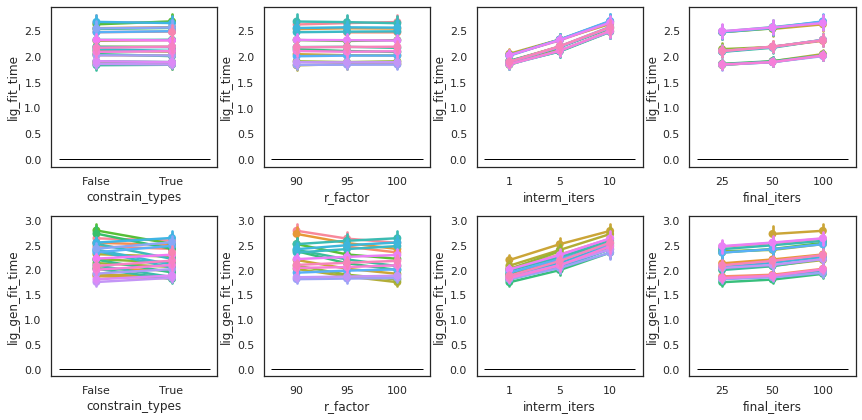

In [6]:
plot_strips('ae_lowrmsdtest0_fit_time_grouped_strips.png', plot_df, x=params,
            y=['lig_fit_time', 'lig_gen_fit_time'], grouped=True, height=3, width=3, point=True, 
            point_kws=dict(alpha=0.0, dodge=False, scale=0.9))
plt.show()

Atom fitting is faster with fewer gradient descent iterations, but all param settings fit a single structure in less than 3 seconds on average, both for true and generated densities, with or without the type constraint. 

When fitting without type constraint, decreasing the radius factor tends to increase the time it takes to fit to generated densities because it leads to more atoms being placed. This effect is not seen when fitting to true densities because **radius factor does not apply when fitting to true densities.**

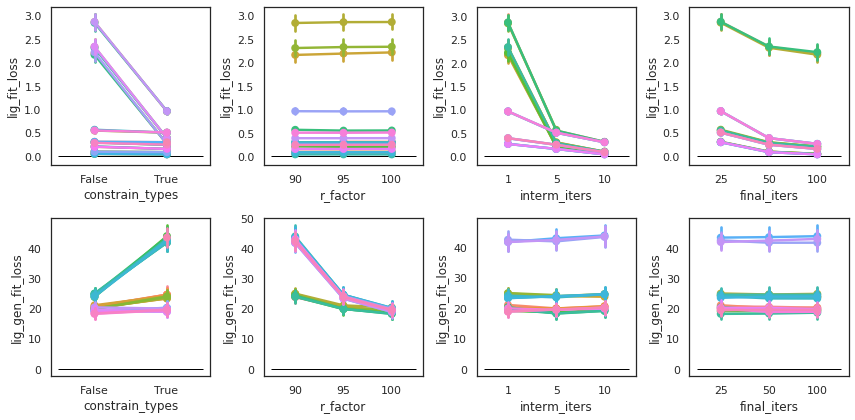

In [7]:
plot_strips('ae_lowrmsdtest0_fit_loss_grouped_strips.png', plot_df, x=params,
            y=['lig_fit_loss', 'lig_gen_fit_loss'], grouped=True, height=3, width=3, point=True, 
            point_kws=dict(alpha=0.0, dodge=False, scale=0.9))
plt.show()

When fitting to true densities, atom fitting loss improves significantly with increased gradient descent iterations, and is especially poor in the case of unconstrained fitting with only one intermediate gradient descent step. As expected, the radius factor has no effect on fitting to true densities.

The number of gradient descent steps has an insignificant effect on atom fitting loss for generated densities. However, radius factor does have an effect on fitting to generated densities, with lower radius factor resulting in worse fit loss, especially when type-constrained.

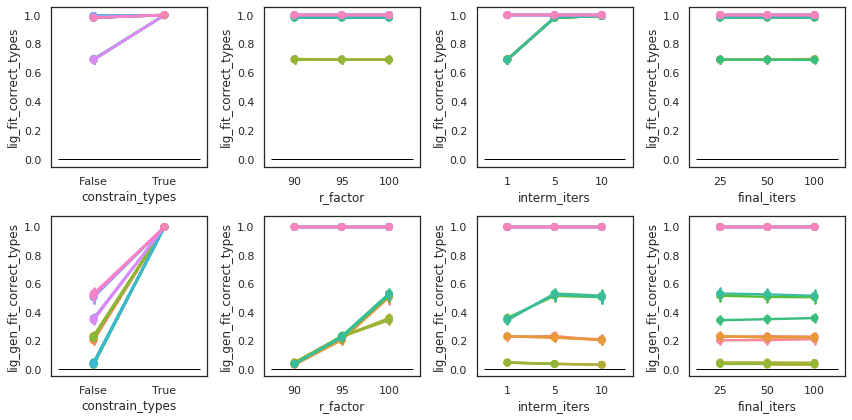

In [8]:
plot_strips('ae_lowrmsdtest0_fit_correct_types_grouped_strips.png', plot_df, x=params,
            y=['lig_fit_correct_types', 'lig_gen_fit_correct_types'], grouped=True, height=3, width=3, point=True, 
            point_kws=dict(alpha=0.0, dodge=False, scale=0.9))
plt.show()

**Type-constrained atom fitting always results in the correct atom types**, by design.

Unconstrained fitting to true densities nearly always produces the correct types, except when only a single intermediate gradient descent step is performed. There may be a very slight disadvantage to fitting with five intermediate steps, compared to ten.

Unconstrained fitting to generated densities is more difficult, producing the correct types for slightly more than 50% of ligands in the best case. Decreasing the radius factor from 100% greatly decreases the abililty to reproduce the correct types from generated densities, and with a radius factor of 100%, using only a single intermediate gradient descent step is worse than using five or ten.

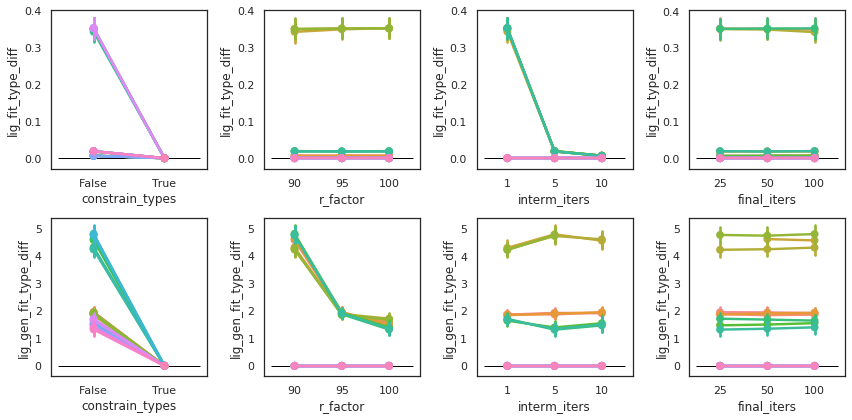

In [9]:
plot_strips('ae_lowrmsdtest0_fit_type_diff_grouped_strips.png', plot_df, x=params,
            y=['lig_fit_type_diff', 'lig_gen_fit_type_diff'], grouped=True, height=3, width=3, point=True, 
            point_kws=dict(alpha=0.0, dodge=False, scale=0.9))
plt.show()

The average number of differences between the fit types and correct types is shown here.

The best settings for unconstrained fitting to generated densities produce less than two differences on average from the correct types: two missing atoms, two extra atoms, or one atom type swap.

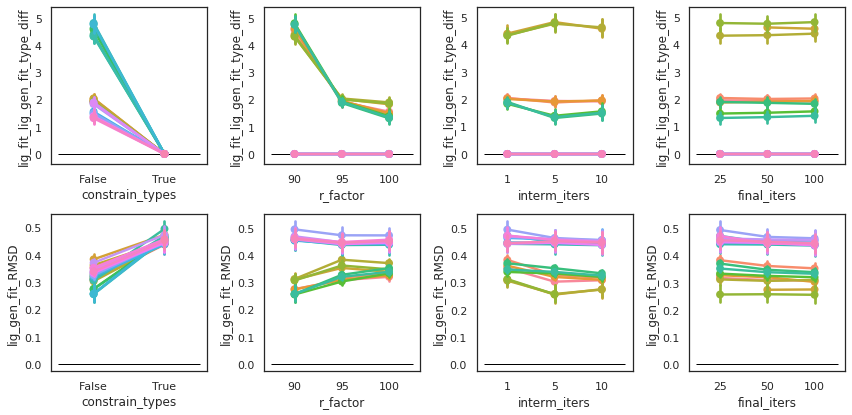

In [10]:
plot_strips('ae_lowrmsdtest0_fit_RMSD_grouped_strips.png', plot_df, x=params,
            y=['lig_fit_lig_gen_fit_type_diff', 'lig_gen_fit_RMSD'], grouped=True, height=3, width=3, point=True, 
            point_kws=dict(alpha=0.0, dodge=False, scale=0.9))
plt.show()

Since it is computed between structures fit to a true density and a generated density, **RMSD is only defined when there are no type differences.**

This is always true when types are constrained, but for unconstrained fitting, the mean type difference is smallest with 100% radius factor. When radius factor is 100%, there may be slightly more type differences using one intermediate gradient descent step than with five or ten.

The best settings for unconstrained fitting produce less than two differences on average between structures fit to true and generated densities: two missing atoms, two extra atoms, or one atom type swap.

The mean RMSD of unconstrained fitting is lower than that of constrained fitting. In addition, decreasing radius factor appears to slightly improve RMSD for unconstrained fitting. However, this is misleading because the total number of structures with no type differences is much lower for unconstrained compared to constrained fitting, and for smaller radius factors in unconstrained fitting.

In [72]:
plot_df.loc['r_1.0_10_100'].describe()

,sample_idx,lig_fit_loss,lig_gen_fit_loss,lig_fit_type_diff,lig_gen_fit_type_diff,lig_fit_time,lig_gen_fit_time,lig_fit_lig_gen_fit_type_diff,lig_gen_fit_RMSD,gen_options,r_factor,interm_iters,final_iters,lig_fit_correct_types,lig_gen_fit_correct_types,lig_fit_error,lig_fit_n_frags,lig_gen_fit_error,lig_gen_fit_n_frags
count,326.0,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,267.000000,326.0,326.0,326.0,326.0,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000
mean,25.0,0.054521,19.541819,0.006626,1.554601,2.674626,2.553300,1.553129,0.320312,1.0,100.0,10.0,100.0,0.993988,0.505153,0.564417,1.014969,0.941718,2.582945
std,0.0,0.111773,20.290709,0.030829,2.621460,1.288729,1.121587,2.614495,0.117240,0.0,0.0,0.0,0.0,0.026219,0.378981,3.139891,0.157618,2.117976,2.374877
min,25.0,0.000022,1.000859,0.000000,0.000000,1.025690,0.963046,0.000000,0.105656,1.0,100.0,10.0,100.0,0.760000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,25.0,0.000084,6.368285,0.000000,0.090000,1.738443,1.686589,0.090000,0.241057,1.0,100.0,10.0,100.0,1.000000,0.120000,0.000000,1.000000,0.000000,1.040000
50%,25.0,0.000200,12.645889,0.000000,0.520000,2.359928,2.296103,0.540000,0.305014,1.0,100.0,10.0,100.0,1.000000,0.520000,0.000000,1.000000,0.000000,1.520000
75%,25.0,0.073301,23.917039,0.000000,1.460000,3.265849,3.249853,1.460000,0.371200,1.0,100.0,10.0,100.0,1.000000,0.920000,0.000000,1.000000,1.000000,2.860000
max,25.0,1.007467,93.629115,0.320000,14.520000,6.593557,5.436156,14.560000,0.783181,1.0,100.0,10.0,100.0,1.000000,1.000000,25.000000,3.000000,20.000000,12.160000


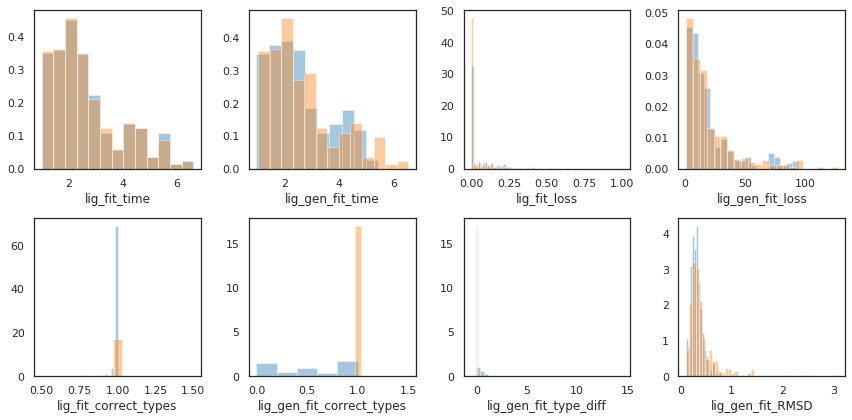

In [12]:
plot_dist('ae_lowrmsdtest0_best_fit_dists.png', plot_df.loc[['r_1.0_10_100', 'rc_1.0_10_100']],
          x=metrics, hue='constrain_types', height=3, width=3, n_cols=4, kde=False)
plt.show()

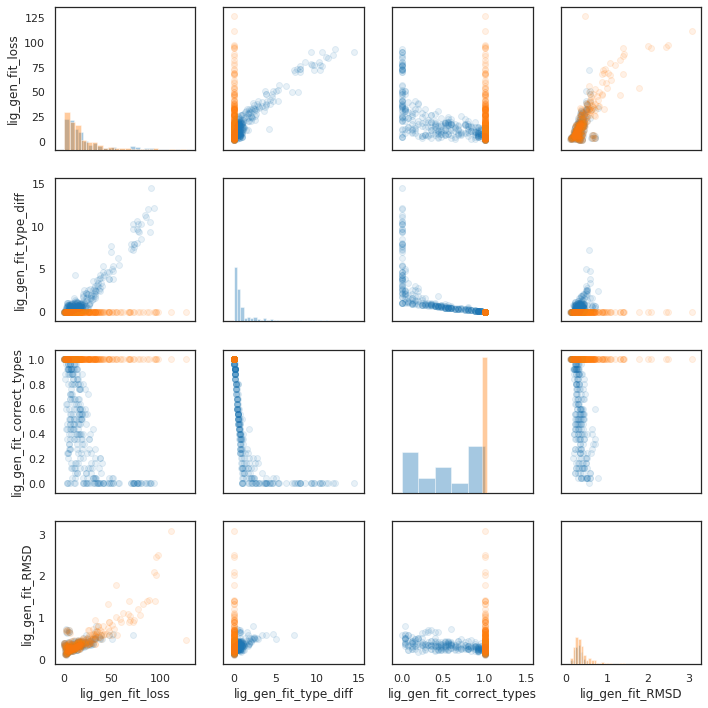

In [30]:
metrics2 = ['lig_gen_fit_loss', 'lig_gen_fit_type_diff', 'lig_gen_fit_correct_types', 'lig_gen_fit_RMSD']
plot_corr('ae_lowrmsdtest0_best_fit_corr.png', plot_df.loc[['r_1.0_10_100', 'rc_1.0_10_100']],
          x=metrics2, y=metrics2, hue='constrain_types', height=2.5, width=2.5,
          dist_kws=dict(kde=False), scatter_kws=dict(alpha=0.1), despine=False)
plt.show()